# **Advanced Topics in Deep Learning** - Gaussian Process Regression with GPyTorch

File : gpytorch_regression_example.ipynb

Author : Billy Carson

Written : 03-06-2021

Last modified : 03-9-2021

> In this notebook we provide a couple of examples to demonstrate how to use the [GPyTorch](https://gpytorch.ai/) framework to train Gaussian process (GP) models. The first example is a modified example from [GPyTorch's documentation](https://docs.gpytorch.ai/en/stable/index.html) that trains a GP regression model on a synthetic dataset. We compare different kernels to demonstrate how kernel choice affects GP generalization properties. In the second example, we train a GP with a spectral mixture kernel on a GPU (if available) on a real world dataset of monthly airline passengers in the U.S. from January 1949 to December 1960. The final example is a texture extrapolation task in which a spectral mixture GP is trained to predict the pattern shown in an image of steel tread walkway.


### **Import modules**

Below we load standard modules as well as modules from the GPyTorch library. Comments above GPyTorch import statements provide a short description of the use and purpose of the imports.


In [1]:
# Import modules
import os
import sys
import math
import time
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt
import torch
from misc_utils import *

# Import GPyTorch
import gpytorch

# Import exact GP model
# ExactGP is the base class for any exact-inference Gaussian process latent function
from gpytorch.models import ExactGP

# Import GPyTorch mean and covariance kernel functions
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, SpectralMixtureKernel

# Import GPyTorch distribution and likelihood
# MultivariateNormal a multivariate normal random variable
from gpytorch.distributions import MultivariateNormal
# GPyTorch likelihood specifies the mapping from latent function values observed labels
from gpytorch.likelihoods import GaussianLikelihood
# module that calculates the exact marginal log likelihood (MLL)
from gpytorch.mlls import ExactMarginalLogLikelihood


# **GP Regression on Synthetic Data**

Our first example demonstrates how to perform GP regression using a sythetic dataset. We'll try multiple covariance kernel functions to see how choice of kernel affects GP behavior and generalization. The following code is modified from an [tutorail](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html) taken from the GPyTorch documentation.


### **Generate synthetic data**

We generate a synthetic dataset on which to train a GP model. The true underlying function $f$ is a simple $sin$ function. Our observations $y(x)$ are then noisy observations of $f(x)$ with added Gaussian noise $\epsilon$.

$f(x) = \sin(2\pi x)$

$\epsilon \sim \mathcal{N}(0, 0.04)$

$y(x) = f(x) + \epsilon$

Once we generate the synthetic dataset, we divide it into training and test splits and convert the arrays to PyTorch float tensors.


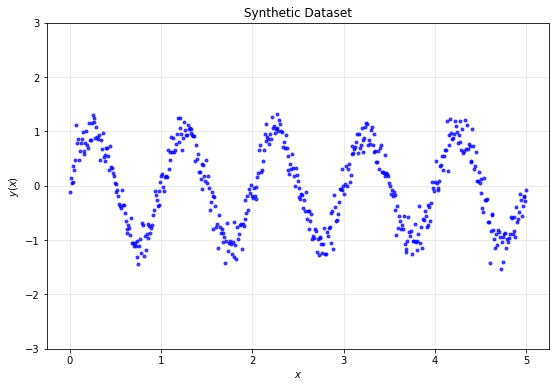

In [2]:
# Data is 500 points in [0,5] inclusive regularly spaced
x_all = np.linspace(0.0, 5.0, 500)

# Generate the true function sin(2*pi*x) from x
f_all = np.sin(x_all * (2 * math.pi))

# Create a vector of Gaussian noise the same size as the data
eps_all = np.random.randn(len(x_all)) * math.sqrt(0.04)

# Add true function f and Gaussian noise to create noisy observations y
y_all = f_all + eps_all

# Visualize airline passenger data
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 6))
ax1.plot(x_all, y_all, 'b.', linewidth=2.0, alpha=0.7)
ax1.set_title('Synthetic Dataset')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y(x)$')
ax1.grid(alpha=0.3)
ax1.set_ylim([-3.0, 3.0])
ax1.set_axisbelow(True)
plt.show()

# Split data into train and test splits
test_pct = 0.6  # train on two periods of the sin function, test on three periods
split_idx = int((1.0 - test_pct) * len(x_all))
x_train = x_all[:split_idx]
x_test = x_all[split_idx:]
y_train = y_all[:split_idx]
y_test = y_all[split_idx:]

# Convert to PyTorch tensors and place
y_train = torch.from_numpy(y_train).float()
x_train = torch.from_numpy(x_train).float()
y_test = torch.from_numpy(y_test).float()
x_test = torch.from_numpy(x_test).float()
y_all = torch.from_numpy(y_all).float()
x_all = torch.from_numpy(x_all).float()


### **Exact GP model with RBF kernel definition**

Here we define a GP model with RBF kernel that inherits from GPyTorch's [ExactGP base class](https://docs.gpytorch.ai/en/v1.1.1/models.html). We define the `mean` attribute of our model to be GPyTorch's constant mean module, and we define the `cov` attribute of our model to be GPyTorch's radial basis function (RBF) kernel module. See GPyTorch's documentation for further information on offered [mean functions](https://docs.gpytorch.ai/en/v1.1.1/means.html) and [kernels](https://docs.gpytorch.ai/en/v1.1.1/kernels.html).


In [3]:
# Simple exact inference GP model with RBF kernel
# Inherit from GPyTorch's ExactGP base class
class RBFGP(ExactGP):
    # Exact GP initialization method
    def __init__(self, x_train, y_train, likelihood):        
        # Inherit from ExactGP
        super(RBFGP, self).__init__(x_train, y_train, likelihood)
        
        # Define mean and covariance functions
        self.mean = ConstantMean()
        self.cov = ScaleKernel(RBFKernel())

    # The forward method that takes in some n×d data x and returns a MultivariateNormal
    # with the prior mean and covariance evaluated at x
    def forward(self, x):
        # Get mean and covariance evaluated at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        
        # Multivariate normal object
        dist = MultivariateNormal(mean_x, cov_x)
        
        # Return multivariate normal object
        return dist


### **Instantiate likelihood and GP model**

Here, we define our likelihood and instantiate our GP model with RBF kernel. A [likelihood in GPyTorch](https://docs.gpytorch.ai/en/v1.1.1/likelihoods.html) specifies the mapping from latent function values $f(x)$ to the observed labels $y$.


In [4]:
# Instantiate likelihood and model
likelihood = GaussianLikelihood()
model = RBFGP(x_train, y_train, likelihood)


### **Define loss and optimizer**

Like many deep learning optimization problems, we have to define a loss and optimization method. We'll train our GP models by minimizing the negative Mariginal Log Likelihood (MLL). Conveniantly, GPyTorch provides a [`ExactMarginalLogLikelihood`](https://docs.gpytorch.ai/en/stable/marginal_log_likelihoods.html) object that, once provided with the model predictions and training data, calculates this for us. For our optimizer, we'll use Adam with a fairly large learning rate of 0.1, since the data is not terribly complex.


In [5]:
# "Loss" for GPs - the marginal log likelihood
# Takes likelihood and model instances as inputs
mll = ExactMarginalLogLikelihood(likelihood, model)

# Adam optimizer instantiation
# Model parameters includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


### **Train GP with an RBF covariance kernel on synthetic dataset**

Now, let's try training a GP with an RBF covariance kernel on the toy dataset we just defined. We'll train fo 100 epochs and display training progress updates every 20 epochs. In addition to reporting the training loss, we can also report model parameters to see how they are changing during training. For this example, we report RBF kernel length scale and the noise parameter.


In [6]:
# Define number of training epochs
n_epochs = 100

# Place model in training mode
model.train()
likelihood.train()

# Train GP model
print('\nTraining GP with RBF kernel...\n')
time_start = time.time()
for epoch in range(n_epochs):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(x_train)
    
    # Calculate loss and backpropagate gradients
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Display training progress
    if (((epoch + 1) % 20) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('Epoch %03d | train loss: %s | length scale: %s | noise: %s' % 
              (epoch + 1, '{:.4f}'.format(loss.item()),
               '{:.4f}'.format(model.cov.base_kernel.lengthscale.item()),
               '{:.4f}'.format(model.likelihood.noise.item())))

# Model training complete
time_end = time.time()
print('\nGP training complete.')
print('Time to train:  %s\n' % (get_converted_time(time_end - time_start)))



Training GP with RBF kernel...

Epoch 001 | train loss: 1.0409 | length scale: 0.6444 | noise: 0.6445
Epoch 020 | train loss: 0.1680 | length scale: 0.2170 | noise: 0.1198
Epoch 040 | train loss: -0.1161 | length scale: 0.2897 | noise: 0.0268
Epoch 060 | train loss: -0.1304 | length scale: 0.3026 | noise: 0.0371
Epoch 080 | train loss: -0.1312 | length scale: 0.3156 | noise: 0.0345
Epoch 100 | train loss: -0.1313 | length scale: 0.3173 | noise: 0.0349

GP training complete.
Time to train:  0 sec



### **Plot GP with RBF kernel posterior predictive distribution**

Once our GP model is trained, we can make predictions on the test data and plot the posterior predictive distribution, including the posterior mean and confidence interval.


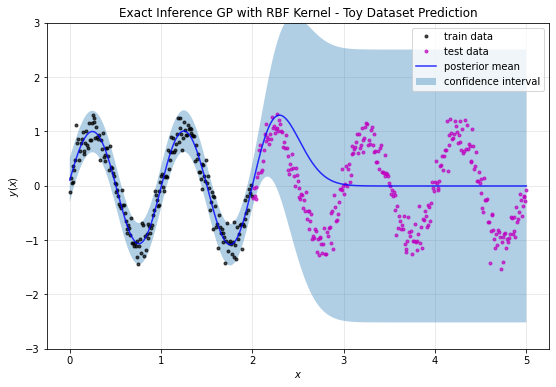

In [7]:
# Place model and likelihood in evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Disabled gradient calculation with no_grad() context-manager
with torch.no_grad():
    # Make predictions by feeding model through likelihood
    post_pred = likelihood(model(x_all))

    # Initialize plot
    fig2, ax2 = plt.subplots(1, 1, figsize=(9, 6))

    # Get upper and lower confidence bounds
    lower, upper = post_pred.confidence_region()
    
    # Get posterior mean
    post_mean = post_pred.mean.numpy()
    
    # Plot training data
    ax2.plot(x_train.numpy(), y_train.numpy(), 'k.', alpha=0.7, label='train data')
    
    # Plot test data
    ax2.plot(x_test.numpy(), y_test.numpy(), 'm.', alpha=0.7, label='test data')
    
    # Plot predictive mean
    ax2.plot(x_all.numpy(), post_mean, 'b', alpha=0.8, label='posterior mean')
    
    # Shade between the lower and upper confidence bounds
    ax2.fill_between(x_all.numpy(), lower.numpy(), upper.numpy(), alpha=0.35, label='confidence interval')
    
    # Format plot
    ax2.set_title('Exact Inference GP with RBF Kernel - Toy Dataset Prediction')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y(x)$')
    ax2.set_ylim([-3, 3])
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    ax2.set_axisbelow(True)

    # Show plot
    plt.show()


### **Train GP with an periodic covariance kernel on toy dataset**

From the posterior prediction generated from the GP with RBF kernel matches the training data fine but doesn't generalize well to the test data. This poor generalization is expected, since our underlying data generating process is periodic. Let's run the same code again, but this time use a periodic kernel for our covariance kernel instead.


### **Periodic GP model definition**

To change our GP model from the previous example, we replace the RBF covariance function with a periodic kernel.


In [8]:
# Exact inference GP model with periodic kernel
class PeriodicGP(ExactGP):
    # Exact GP initialization method
    def __init__(self, x_train, y_train, likelihood):        
        # Inherit from ExactGP
        super(PeriodicGP, self).__init__(x_train, y_train, likelihood)
        
        # Define mean and covariance functions
        self.mean = ConstantMean()
        self.cov = PeriodicKernel()

    # Periodic GP forward method
    def forward(self, x):
        # Get mean and covariance evaluated at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        
        # Multivariate normal object
        dist = MultivariateNormal(mean_x, cov_x)
        
        # Return multivariate normal object
        return dist


### **Train GP with an periodic covariance kernel on toy dataset**

In addition to reporting on covariance kernel parameters such as length scale during training, we can also report on the period parameter since this kernel is now trying to model the periodicity of the data. From reporting the period parameter during training, we can see the model gets within a couple of thousandths of predicting the actual period of the data.


In [9]:
# Instantiate likelihood and model
likelihood = GaussianLikelihood()
model = PeriodicGP(x_train, y_train, likelihood)

# "Loss" for GPs - the marginal log likelihood
# Takes likelihood and model instances as inputs
mll = ExactMarginalLogLikelihood(likelihood, model)

# Use the adam optimizer
# Model parameters includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define number of training epochs
n_epochs = 100

# Place model in training mode
model.train()
likelihood.train()

# Train GP model
print('\nTraining GP with periodic kernel...\n')
time_start = time.time()
for epoch in range(n_epochs):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(x_train)
    
    # Calculate loss and backpropagate gradients
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Display training progress
    if (((epoch + 1) % 20) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('Epoch %03d | train loss: %s | length scale: %s | period: %s | noise: %s' % 
              (epoch + 1, '{:.4f}'.format(loss.item()),
               '{:.4f}'.format(model.cov.lengthscale.item()),
               '{:.4f}'.format(model.cov.period_length.item()),
               '{:.4f}'.format(model.likelihood.noise.item())))

# Model training complete
time_end = time.time()
print('\nGP training complete.')
print('Time to train:  %s\n' % (get_converted_time(time_end - time_start)))



Training GP with periodic kernel...

Epoch 001 | train loss: 1.2089 | length scale: 0.7444 | period: 0.7444 | noise: 0.6445
Epoch 020 | train loss: 0.2083 | length scale: 2.0388 | period: 0.9637 | noise: 0.1278
Epoch 040 | train loss: -0.1855 | length scale: 3.3412 | period: 1.0131 | noise: 0.0269
Epoch 060 | train loss: -0.1956 | length scale: 4.1816 | period: 1.0026 | noise: 0.0367
Epoch 080 | train loss: -0.1981 | length scale: 4.6350 | period: 1.0007 | noise: 0.0331
Epoch 100 | train loss: -0.1985 | length scale: 4.8846 | period: 1.0021 | noise: 0.0343

GP training complete.
Time to train:  0 sec



### **Plot periodic GP posterior predictive distribution**

As we can see from the plot below, the posterior predictive mean of the periodic GP is much better suited to the sythetic dataset.


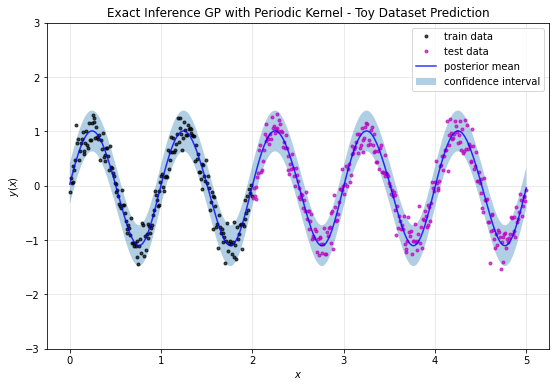

In [10]:
# Place model and likelihood in evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Disabled gradient calculation with no_grad() context-manager
with torch.no_grad():
    # Make predictions by feeding model through likelihood
    post_pred = likelihood(model(x_all))

    # Initialize plot
    fig3, ax3 = plt.subplots(1, 1, figsize=(9, 6))

    # Get upper and lower confidence bounds
    lower, upper = post_pred.confidence_region()
    
    # Get posterior mean
    post_mean = post_pred.mean.numpy()
    
    # Plot training data
    ax3.plot(x_train.numpy(), y_train.numpy(), 'k.', alpha=0.7, label='train data')
    
    # Plot test data
    ax3.plot(x_test.numpy(), y_test.numpy(), 'm.', alpha=0.7, label='test data')
    
    # Plot predictive mean
    ax3.plot(x_all.numpy(), post_mean, 'b', alpha=0.8, label='posterior mean')
    
    # Shade between the lower and upper confidence bounds
    ax3.fill_between(x_all.numpy(), lower.numpy(), upper.numpy(), alpha=0.35, label='confidence interval')
    
    # Format plot
    ax3.set_title('Exact Inference GP with Periodic Kernel - Toy Dataset Prediction')
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$y(x)$')
    ax3.set_ylim([-3, 3])
    ax3.legend(loc='upper right')
    ax3.grid(alpha=0.3)
    ax3.set_axisbelow(True)

    # Show plot
    plt.show()


# **Airline Passengers Dataset**

Next, let's train a GP on a real world dataset. Here, we'll fit a GP model to predict [U.S. monthly airline passengers in the 1950s](https://github.com/jbrownlee/Datasets/blob/master/airline-passengers.csv). Instead of an RBF or periodic kernel, we'll use a spectral mixture (SM) kernel for our covariance function. We show one of the better posterior predictions made by the model. In practice, fitting a GP with gradient-based methods does not always produce the same result.


### **Load and format airline passenger data**

First, let's load the airline passenger dataset from the .csv file, visualize the data, and transform our data into PyTorch tensors. Before training, we will be scaling the training data to have zero mean and unit standard deviation, as empirically I have found this to help trianing stability some.


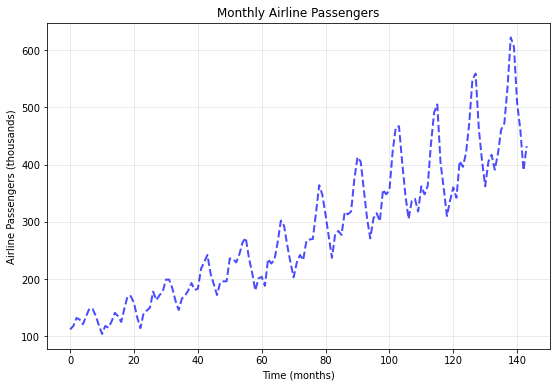

In [11]:
# Load airline passenger data
airline_df = pd.read_csv('airline_passenger_data.csv')
airline_data = np.array(airline_df['Passengers'].values)

# Visualize airline passenger data
fig4, ax4 = plt.subplots(1, 1, figsize=(9, 6))
ax4.plot(airline_data, 'b--', linewidth=2.0, alpha=0.7)
ax4.set_title('Monthly Airline Passengers')
ax4.set_xlabel('Time (months)')
ax4.set_ylabel('Airline Passengers (thousands)')
ax4.grid(alpha=0.3)
ax4.set_axisbelow(True)
plt.show()

# Split data into train and test splits
y_all = airline_data.copy()
x_all = np.arange(len(y_all))
test_pct = 0.3
split_idx = int((1.0 - test_pct) * len(airline_data))
y_train = y_all[:split_idx]
x_train = x_all[:split_idx]
y_test = y_all[split_idx:]
x_test = x_all[split_idx:]

# Scale training data to have mean 0 and unit standard deviation
# Empirically, scaling in the above way helps the spectral mixture fit better
y_train_mean = np.mean(y_train)
y_train_std = np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Convert data to PyTorch tensors
x_all = torch.from_numpy(x_all).float()
y_all = torch.from_numpy(y_all).float()
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()


### **Spectral mixture GP model definition**

Here we define the spectral mixture GP model. We will use a linear mean since from our visualization of the data it's clear the general trend of number of monthly airline passengers is increasing over time.


In [12]:
# Exact inference GP model with spectral mixture kernel
class SpectralMixtureGP(ExactGP):
    # Exact GP initialization method
    def __init__(self, x_train, y_train, likelihood, num_mixtures):        
        # Inherit from ExactGP
        super(SpectralMixtureGP, self).__init__(x_train, y_train, likelihood)
        
        # Define mean and covariance functions
        self.mean = LinearMean(input_size=1)
        self.cov = SpectralMixtureKernel(num_mixtures=num_mixtures)
        self.cov.initialize_from_data_empspect(train_x=x_train, train_y=y_train)

    # SM GP forward method
    def forward(self, x):
        # Get mean and covariance evaluated at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        
        # Multivariate normal object
        dist = MultivariateNormal(mean_x, cov_x)
        
        # Return multivariate normal object
        return dist


### **Train GP on airline passengers data**




In [13]:
# Instantiate likelihood and model
likelihood = GaussianLikelihood()
# model = SpectralMixtureGP(x_train, y_train, likelihood, num_mixtures=4).to(device)
model = SpectralMixtureGP(x_train, y_train, likelihood, num_mixtures=4)

# "Loss" for GPs - the marginal log likelihood
# Takes likelihood and model instances as inputs
mll = ExactMarginalLogLikelihood(likelihood, model)

# RMSprop optimizer - in practice this optimizer produces better results than Adam
# Model parameters includes GaussianLikelihood parameters
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0008)

# Define number of training epochs
n_epochs = 10000

# Initialize model checkpoint variables
checkpoint_path = 'model_state.pt'
loss_min = sys.maxsize

# Place model in training mode
model.train()
likelihood.train()

# Train GP model
print('\nTraining GP with spectral mixture kernel...\n')
time_start = time.time()
for epoch in range(n_epochs):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(x_train)
    
    # Calculate loss and backpropagate gradients
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Checkpoint model based on loss
    if loss.item() < loss_min:
        torch.save(model.state_dict(), checkpoint_path)
        loss_min = loss.item()
    
    # Display training progress
    if (((epoch + 1) % 1000) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('Epoch %05d | train loss: %s | noise: %s' % 
              (epoch + 1, '{:.4f}'.format(loss.item()),
               '{:.4f}'.format(model.likelihood.noise.item())))

# Model training complete
time_end = time.time()
print('\nGP training complete.')
print('Time to train:  %s\n' % (get_converted_time(time_end - time_start)))

# Load best model (lowest loss) from saved state dictionary and delete state dictionary checkpoint
model.load_state_dict(torch.load(checkpoint_path))
os.remove(checkpoint_path)



Training GP with spectral mixture kernel...

Epoch 00001 | train loss: 90.8772 | noise: 0.6973
Epoch 01000 | train loss: 1.0029 | noise: 0.7017
Epoch 02000 | train loss: 0.6108 | noise: 0.3714
Epoch 03000 | train loss: 0.3025 | noise: 0.1833
Epoch 04000 | train loss: 0.0265 | noise: 0.0874
Epoch 05000 | train loss: -0.1808 | noise: 0.0416
Epoch 06000 | train loss: -0.2578 | noise: 0.0225
Epoch 07000 | train loss: -0.2604 | noise: 0.0216
Epoch 08000 | train loss: -0.2614 | noise: 0.0214
Epoch 09000 | train loss: -0.2614 | noise: 0.0214
Epoch 10000 | train loss: -0.2614 | noise: 0.0215

GP training complete.
Time to train:  30 sec



### **Visualize airline passengers predictions**

Let's visualize the predictions made by our spectral mixture GP on the airline passengers dataset. We show one of the better posterior predictions made by the model. In practice, fitting a GP with gradient-based methods does not always produce the same result.


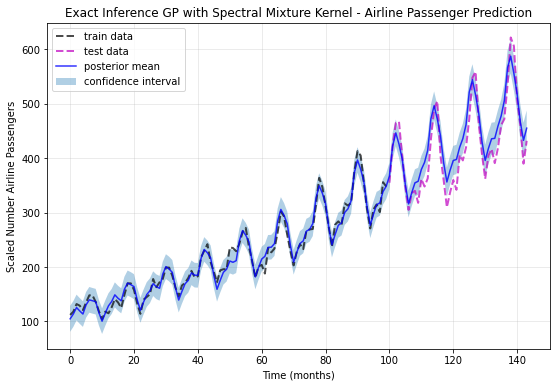

In [14]:
# Place model and likelihood in evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Disabled gradient calculation with no_grad() context-manager
with torch.no_grad():
    # Make predictions by feeding model through likelihood
    post_pred = likelihood(model(x_all))
    
    # Get posterior mean
    post_mean = post_pred.mean.numpy()

    # Initialize plot
    fig5, ax5 = plt.subplots(1, 1, figsize=(9, 6))

    # Get upper and lower confidence bounds
    lower, upper = post_pred.confidence_region()
    
    # Plot training data
    ax5.plot(x_train.numpy(), (y_train_std * y_train.numpy()) + y_train_mean, 'k--', linewidth=2.0, alpha=0.7, label='train data')
    
    # Plot test data
    ax5.plot(x_test.numpy(), (y_train_std * y_test.numpy()) + y_train_mean, 'm--', linewidth=2.0, alpha=0.7, label='test data')
    
    # Plot predictive mean
    ax5.plot(x_all.numpy(), (y_train_std * post_mean) + y_train_mean, 'b', alpha=0.8, label='posterior mean')
    
    # Shade between the lower and upper confidence bounds
    ax5.fill_between(x_all.numpy(), (y_train_std * lower.numpy()) + y_train_mean,
                     (y_train_std * upper.numpy()) + y_train_mean, alpha=0.35, label='confidence interval')
    
    # Format plot
    ax5.set_title('Exact Inference GP with Spectral Mixture Kernel - Airline Passenger Prediction')
    ax5.set_xlabel('Time (months)')
    ax5.set_ylabel('Scaled Number Airline Passengers')
    ax5.legend(loc='upper left')
    ax5.grid(alpha=0.3)
    ax5.set_axisbelow(True)

    # Show plot
    plt.show()


# **Texture Extrapolation**

For our final example we'll be performing a texture extrapolation task by training on one half of an image and evaluating our model on the prediction made for the second half of the image. This is is similar to one of the experiments from [Benton et al. (2019)](https://arxiv.org/abs/1910.13565), in which they performed texture extrapolation using their proposed GP model (Figure 9 in their paper).

For this problem we'll be training on half of a 66$\times$100 image for 3,300 training points in total. Since this data is on the larger side for GPs, we'll leverage one of GPyTorch's most useful features for training our GP - [GPU acceleration](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/Simple_GP_Regression_CUDA.html?highlight=gpu#Using-the-GPU).


### **Enable GPU compute**

First, we need to make sure we can train our model on the GPU. If CUDA is available and a GPU is detected, we'll set variable `device` to `'cuda:0'`. If there is no GPU available, we'll continue training on the CPU and set device to `'cpu'`.


In [15]:
# Enable GPU compute if CUDA is avialable
# device = 'cpu'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Display device
print('\nDevice:  %s\n' % (str(device)))



Device:  cuda:0



### **Image data transformation functions**

Here we define some functions we'll need for working with image data. The first function, `img_to_data()`, takes a single-channel 2D grayscale image as input and returns data in an array of training inputs `x` and an array of targets `y`. The entries in `x` are the numerical values of the pixel location in the image, and the entries in `y` correspond to the pixel value or intensity.

The second function, `data_to_img()`, is the function we'll use to transform the predictions made by the GP back to image format so we can visualize them and compare to the original image. The function takes input and target arrays `x` and `y` as input, as well as the dimensions of the image to be generated.


In [16]:
# Converts 2D image array to input and output arrays (x and y)
def img_to_data(img_arr):
    # Ensure image array only has two dimesions
    # Multi-channel RGB images not supported
    assert(len(img_arr.shape) == 2)
    
    # Get size of first and second image dimensions
    dim_1 = img_arr.shape[0]
    dim_2 = img_arr.shape[1]
    
    # Initialize input features and output arrays
    x = np.zeros((dim_1 * dim_2, 2))
    y = np.zeros((dim_1 * dim_2))
    
    # Populate input features and output arrays
    for j in range(dim_2):
        for i in range(dim_1):
            x[(i * dim_2) + j, 0] = i
            x[(i * dim_2) + j, 1] = j
            y[(i * dim_2) + j] = img_arr[i, j]
    
    # Return data
    return x, y

# Converts input features and output arrays into image
def data_to_img(x, y, dim_1, dim_2):
    # Ensure input and output arrays are appropriate shape for given image dimensions
    assert(x.shape[0] == (dim_1 * dim_2))
    assert(y.shape[0] == (dim_1 * dim_2))
    
    # Initialize image array
    img_arr = np.zeros((dim_1, dim_2))
    
    # Populate image array with predicted pixel values
    for j in range(dim_2):
        for i in range(dim_1):
            img_arr[int(x[(i * dim_2) + j, 0]), int(x[(i * dim_2) + j, 1])] = y[(i * dim_2) + j]

    # Return image array
    return img_arr


### **Load texture image**

Here we load a picture of stainless-steel anti slip treads on which we will be performing texture extrapolation. Training on the picture at the original resolution proved too memory-intensive, so we'll use a down-sampled version (metal_grid_resized.jpg). If this image version is still too memory-intensive for your system, try loading the even smaller picture metal_grid_small.jpg instead.



Image shape:  (66, 100)



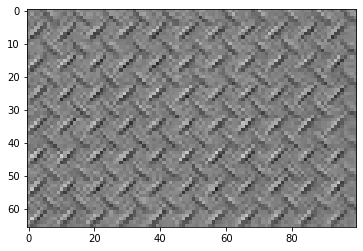

In [17]:
# Load resized picture of steel tread
# img = Image.open('steel_tread_small.jpg').convert("L")
img = Image.open('steel_tread_resized.jpg').convert("L")
img_arr = np.asarray(img)
print('\nImage shape:  (%d, %d)\n' % (img_arr.shape))

# Display picture
fig6, ax6 = plt.subplots(nrows=1, ncols=1)
ax6.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
plt.show()

# Convert picture to input and output arrays (x and y)
x_all, y_all = img_to_data(img_arr=img_arr)

# Split data into train and test splits
test_pct = 0.5
split_idx = int((1.0 - test_pct) * len(x_all))
y_train = y_all[:split_idx]
x_train = x_all[:split_idx]
y_test = y_all[split_idx:]
x_test = x_all[split_idx:]

# Scale training data to have mean 0 and unit standard deviation
# Empirically, scaling in the above way helps the spectral mixture fit better
y_train_mean = np.mean(y_train)
y_train_std = np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Convert to PyTorch tensors and place on pre-specified device
y_train = torch.from_numpy(y_train).float().to(device)
x_train = torch.from_numpy(x_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_all = torch.from_numpy(y_all).float().to(device)
x_all = torch.from_numpy(x_all).float().to(device)


### **Spectral mixture GP model definition**

The definition of the spectral mixture GP we'll use for texture extrapolation is very similar to the model we defined for the prediction of airline passengers; however, here instead of a linear mean function we'll use a constant mean function. This is because, judging from the displayed texture image, the distribution of pixel intensity values as a function of pixel location seem to be centered around some mean intensity.


In [18]:
# Exact inference GP model with spectral mixture kernel
class SpectralMixtureGP(ExactGP):
    # Exact GP initialization method
    def __init__(self, x_train, y_train, likelihood, num_mixtures, input_size=1):        
        # Inherit from ExactGP
        super(SpectralMixtureGP, self).__init__(x_train, y_train, likelihood)
        
        # Define mean and covariance functions
        self.mean = ConstantMean(input_size=input_size)
        self.cov = SpectralMixtureKernel(num_mixtures=num_mixtures, ard_num_dims=input_size)
        self.cov.initialize_from_data_empspect(train_x=x_train, train_y=y_train)

    # SM GP forward method
    def forward(self, x):
        # Get mean and covariance evaluated at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        
        # Multivariate normal object
        dist = MultivariateNormal(mean_x, cov_x)
        
        # Return multivariate normal object
        return dist


### **Train spectral mixture GP on texture extrapolation task**

In [19]:
# Instantiate likelihood and model
likelihood = GaussianLikelihood()
model = SpectralMixtureGP(x_train, y_train, likelihood, num_mixtures=10, input_size=2).to(device)

# "Loss" for GPs - the marginal log likelihood
# Takes likelihood and model instances as inputs
mll = ExactMarginalLogLikelihood(likelihood, model)

# Model parameters includes GaussianLikelihood parameters
# optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define number of training epochs
n_epochs = 500

# Initialize model checkpoint variables
checkpoint_path = 'model_state.pt'
loss_min = sys.maxsize

# Place model in training mode
model.train()
likelihood.train()

# Train GP model
print('\nTraining GP with spectral mixture kernel...\n')
time_start = time.time()
for epoch in range(n_epochs):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(x_train)
    
    # Calculate loss and backpropagate gradients
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Checkpoint model based on loss
    if loss.item() < loss_min:
        torch.save(model.state_dict(), checkpoint_path)
        loss_min = loss.item()
    
    # Display training progress
    if (((epoch + 1) % 50) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('Epoch %04d | train loss: %s | noise: %s' % 
              (epoch + 1, '{:.4f}'.format(loss.item()),
               '{:.4f}'.format(model.likelihood.noise.item())))

# Model training complete
time_end = time.time()
print('\nGP training complete.')
print('Time to train:  %s\n' % (get_converted_time(time_end - time_start)))

# Load best model (lowest loss) from saved state dictionary and delete state dictionary checkpoint
model.load_state_dict(torch.load(checkpoint_path))
os.remove(checkpoint_path)



Training GP with spectral mixture kernel...

Epoch 0001 | train loss: 1.2119 | noise: 0.6883
Epoch 0050 | train loss: 0.9435 | noise: 0.4731
Epoch 0100 | train loss: 0.8808 | noise: 0.3390
Epoch 0150 | train loss: 0.8585 | noise: 0.2867
Epoch 0200 | train loss: 0.8497 | noise: 0.2779
Epoch 0250 | train loss: 0.8446 | noise: 0.2738
Epoch 0300 | train loss: 0.8379 | noise: 0.2628
Epoch 0350 | train loss: 0.8467 | noise: 0.2565
Epoch 0400 | train loss: 0.8388 | noise: 0.2533
Epoch 0450 | train loss: 0.8732 | noise: 0.2574
Epoch 0500 | train loss: 0.8370 | noise: 0.2704

GP training complete.
Time to train:  48 sec



### **Texture extrapoloation predictions**

Finally, let's plot the texture extapolation predicictions made by the SM GP. Specifically, we'll plot the predictive mean of the posterior predictive distribution. Since the GP was trained on the left half of the steel tread image, we'll plot the real image on the left half of the plot and the prediction on the right, demarcated with a vertical red line.


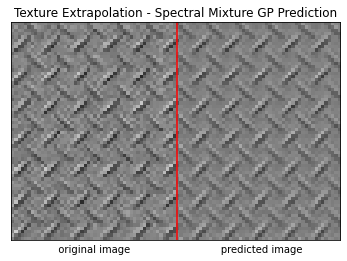

In [20]:
# Place model and likelihood in evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Disabled gradient calculation with no_grad() context-manager
with torch.no_grad():
    # Make predictions by feeding model through likelihood
    post_pred = likelihood(model(x_all))

    # Get posterior mean
    post_mean = post_pred.mean.cpu().numpy()
    
    # Convert predictive mean into predicted image
    img_pred_arr = data_to_img(x_all.cpu().numpy(), post_mean, dim_1=img_arr.shape[0], dim_2=img_arr.shape[1])
    img_pred_arr = (y_train_std * img_pred_arr) + y_train_mean
    
    # Combine original image and predicted image into one array
    img_combined_arr = np.concatenate((img_arr[:, :int(0.5 * img_arr.shape[1])],
                                       img_pred_arr[:, int(0.5 * img_arr.shape[1]):]), axis=1)
    
    # Plot image and predicted image in same plot
    fig7, ax7 = plt.subplots(nrows=1, ncols=1)
    ax7.imshow(img_combined_arr, cmap='gray', vmin=0, vmax=255)
    ax7.axvline(x=int(0.5 * img_arr.shape[1]), c='r')
    
    # Format plot
    ax7.set_title('Texture Extrapolation - Spectral Mixture GP Prediction')
    ax7.set_xlabel('   original image                             predicted image')
    ax7.set_xticks([])
    ax7.set_yticks([])

    # Show plot
    plt.show()
